In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, accuracy_score, classification_report, auc, ConfusionMatrixDisplay


# To remove warnings
import warnings
warnings.filterwarnings("ignore")

# importing data

In [104]:
df=pd.read_csv("fraud.csv")

In [105]:
# Extract information about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [106]:
# Checking for missing values in each column
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [107]:
df.duplicated().sum()

1081

In [108]:
df.drop_duplicates(inplace=True)
df.shape

(283726, 31)

# EDA

In [109]:
# Viewing of legit & fraudulent transactions
df['Class'].value_counts()

Class
0    283253
1       473
Name: count, dtype: int64

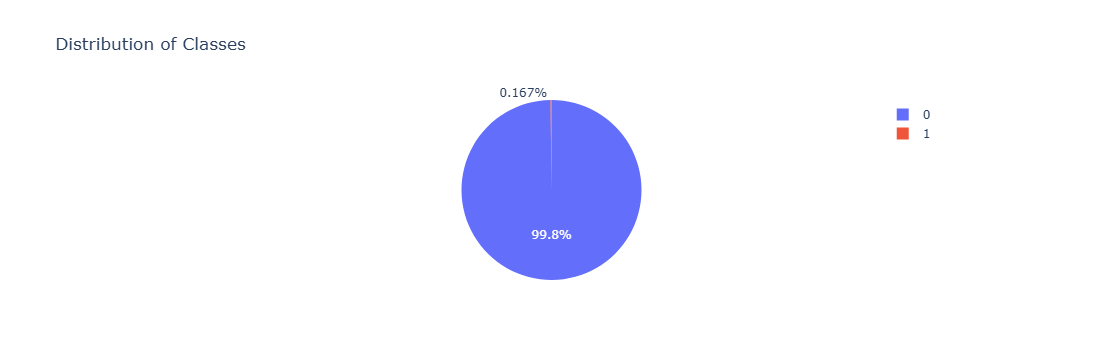

In [110]:
fig = px.pie(data_frame = df,names = 'Class',title = 'Distribution of Classes',)
fig.show()

<bound method Axes.set of <Axes: >>

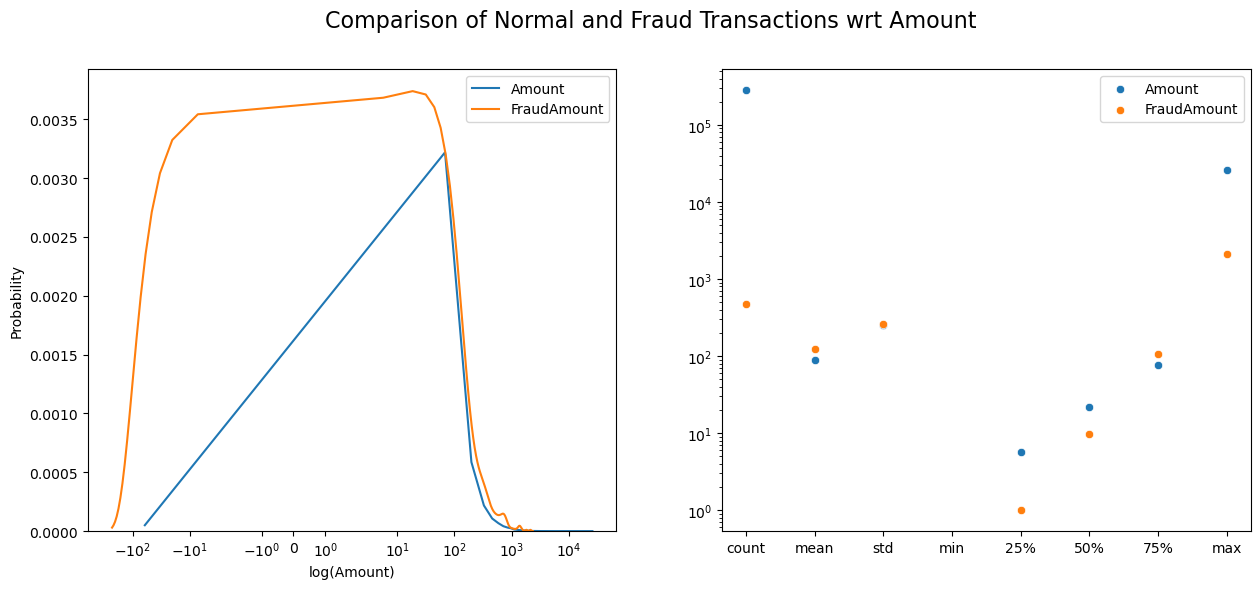

In [111]:
# Ensure that the 'Amount' column does not have inf values by replacing them with NaN
df['Amount'] = df['Amount'].replace([np.inf, -np.inf], np.nan)

# Optionally, drop rows where 'Amount' is NaN
df = df.dropna(subset=['Amount'])

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Comparison of Normal and Fraud Transactions wrt Amount', fontsize=16)

# KDE plot
sns.kdeplot(df[df['Class'] == 0]['Amount'], label='Amount', ax=ax[0])
sns.kdeplot(df[df['Class'] == 1]['Amount'], label='FraudAmount', ax=ax[0])
ax[0].set_xscale('symlog')
ax[0].set_xlabel('log(Amount)')
ax[0].set_ylabel('Probability')
ax[0].legend()  # Ensure the legend is added to the first plot

# Scatter plot of summary statistics
stats_normal = df[df['Class'] == 0]['Amount'].describe()
stats_fraud = df[df['Class'] == 1]['Amount'].describe()

sns.scatterplot(x=stats_normal.index, y=stats_normal.values, label='Amount', ax=ax[1])
sns.scatterplot(x=stats_fraud.index, y=stats_fraud.values, label='FraudAmount', ax=ax[1])

ax[1].set_yscale('log')
ax[1].set


In [112]:
# Separating the legit & fraudulent data for analysis
legit = df[df.Class == 0]  # 0 --> normal transaction
fraud = df[df.Class == 1]  # 1 --> fraudulent transaction

print(legit.shape)
print(fraud.shape)

(283253, 31)
(473, 31)


In [113]:
# Statistical descriptive analysis of the data
legit.Amount.describe()

count    283253.000000
mean         88.413575
std         250.379023
min           0.000000
25%           5.670000
50%          22.000000
75%          77.460000
max       25691.160000
Name: Amount, dtype: float64

In [114]:
fraud.Amount.describe()

count     473.000000
mean      123.871860
std       260.211041
min         0.000000
25%         1.000000
50%         9.820000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [115]:
# Compare for the both type of transactions
df.groupby('Class').mean()

Time        V1        V2        V3        V4        V5  \
Class                                                                   
0      94835.058093  0.013439 -0.009829  0.012853 -0.010440  0.006769   
1      80450.513742 -4.498280  3.405965 -6.729599  4.472591 -2.957197   

             V6        V7        V8        V9  ...       V20      V21  \
Class                                          ...                      
0      0.001251  0.010447 -0.002448  0.002613  ... -0.000489 -0.00115   
1     -1.432518 -5.175912  0.953255 -2.522124  ...  0.405043  0.46655   

            V22       V23       V24       V25       V26       V27       V28  \
Class                                                                         
0     -0.000160  0.000360  0.000393 -0.000301  0.000065  0.001409  0.000418   
1      0.086639 -0.096464 -0.106643  0.040615  0.050456  0.213774  0.078270   

           Amount  
Class              
0       88.413575  
1      123.871860  

[2 rows x 30 columns]

From the avobe analysis we can see thst the dataset is highly imbalanced according to the amount of fraude transection and ligal transections.

### Construct data
#### Under-Sampling

Create a sample dataset with a distribution of legitimate and fraudulent transactions that is comparable.

492 is the number of fraudulent transactions.

In [116]:
l_transaction_sample = legit.sample(n=492)

In [117]:
# Create a new dataframe by concatanatind 2 dataframe
df_new = pd.concat([l_transaction_sample, fraud], axis=0)

df_new.head()

Time        V1        V2        V3        V4        V5        V6  \
135633   81335.0 -0.749285  1.184899  0.982722 -0.352147 -0.165374 -0.975103   
191009  129071.0  1.534727 -1.167011 -1.154164  0.027534  0.376491  1.860681   
254184  156617.0 -1.175988 -1.032252  1.777337 -2.790824 -0.154468 -1.002649   
230710  146448.0 -0.057825  0.083566 -1.327211 -0.590205  0.469576  0.025377   
182238  125316.0 -1.855876  0.493221  2.855245  4.233285 -0.030151  1.577838   

              V7        V8        V9  ...       V21       V22       V23  \
135633  0.365716  0.443169 -0.795949  ... -0.050464 -0.399442  0.126330   
191009 -0.527059  0.563712  0.909286  ... -0.242910 -0.938251  0.346491   
254184 -0.543825 -0.077095 -2.011161  ... -0.117275 -0.035280 -0.182272   
230710  1.788616 -0.138545 -0.510704  ...  0.459509  0.859511  0.505298   
182238 -0.199289  0.235247 -0.295872  ... -0.189063  0.758694  0.287296   

             V24       V25       V26       V27       V28  Amount  Class  
135633  0.469573 -0.749525 -0.171372 -0.014603  0.102722    2.69      0  
191009 -0.968297 -0.845225  0.208149 -0.040564 -0.036227  192.40      0  
254184 -0.102453  0.642020 -0.137287 -0.132957  0.158268    4.40      0  
230710  0.120044 -0.548374  0.479436 -0.026495  0.123513  279.86      0  
182238 -0.460262  0.252910  0.576851  0.609942 -0.167934   51.02      0  

[5 rows x 31 columns]

In [118]:
df_new['Class'].value_counts()

Class
0    492
1    473
Name: count, dtype: int64

In [119]:
df_new.groupby('Class').mean()

Time        V1        V2        V3        V4        V5  \
Class                                                                   
0      97241.516260 -0.104486 -0.033822 -0.093379 -0.031657  0.072882   
1      80450.513742 -4.498280  3.405965 -6.729599  4.472591 -2.957197   

             V6        V7        V8        V9  ...       V20       V21  \
Class                                          ...                       
0     -0.050759  0.068790 -0.013627 -0.007790  ...  0.004135  0.015484   
1     -1.432518 -5.175912  0.953255 -2.522124  ...  0.405043  0.466550   

            V22       V23       V24       V25       V26       V27      V28  \
Class                                                                        
0      0.074572  0.016570  0.010862  0.025525  0.000341 -0.014798  0.00290   
1      0.086639 -0.096464 -0.106643  0.040615  0.050456  0.213774  0.07827   

           Amount  
Class              
0       94.493841  
1      123.871860  

[2 rows x 30 columns]

<bound method Axes.set of <Axes: >>

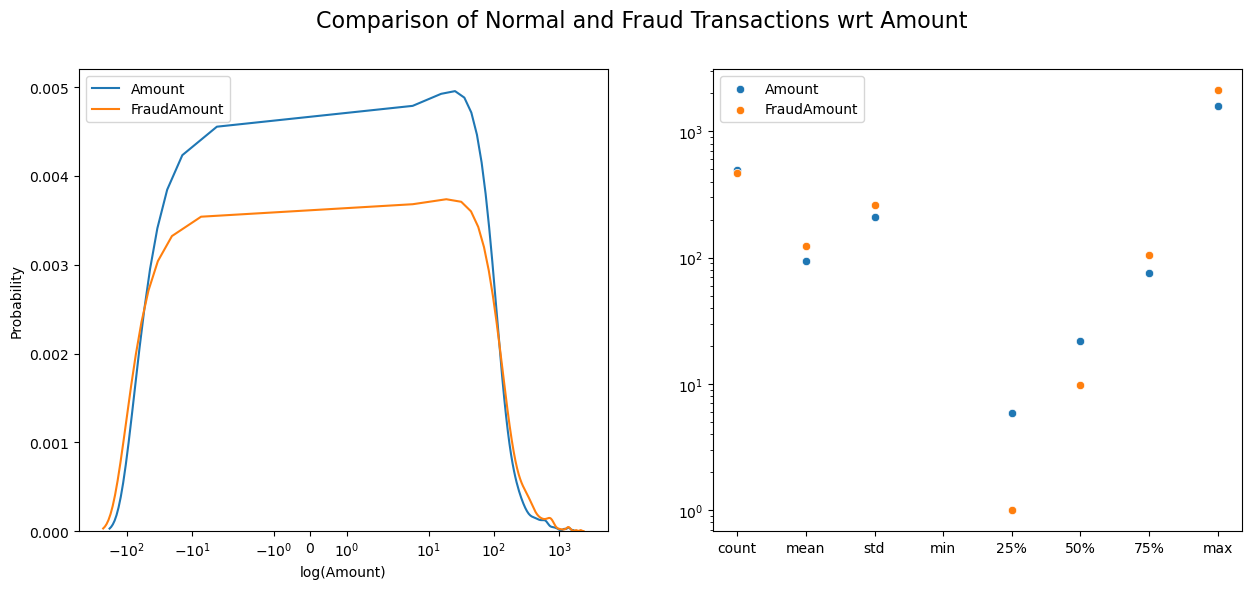

In [120]:
# Ensure that the 'Amount' column does not have inf values by replacing them with NaN
df['Amount'] = df_new['Amount'].replace([np.inf, -np.inf], np.nan)

# Optionally, drop rows where 'Amount' is NaN
df = df.dropna(subset=['Amount'])

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Comparison of Normal and Fraud Transactions wrt Amount', fontsize=16)

# KDE plot
sns.kdeplot(df[df['Class'] == 0]['Amount'], label='Amount', ax=ax[0])
sns.kdeplot(df[df['Class'] == 1]['Amount'], label='FraudAmount', ax=ax[0])
ax[0].set_xscale('symlog')
ax[0].set_xlabel('log(Amount)')
ax[0].set_ylabel('Probability')
ax[0].legend()  # Ensure the legend is added to the first plot

# Scatter plot of summary statistics
stats_normal = df[df['Class'] == 0]['Amount'].describe()
stats_fraud = df[df['Class'] == 1]['Amount'].describe()

sns.scatterplot(x=stats_normal.index, y=stats_normal.values, label='Amount', ax=ax[1])
sns.scatterplot(x=stats_fraud.index, y=stats_fraud.values, label='FraudAmount', ax=ax[1])

ax[1].set_yscale('log')
ax[1].set

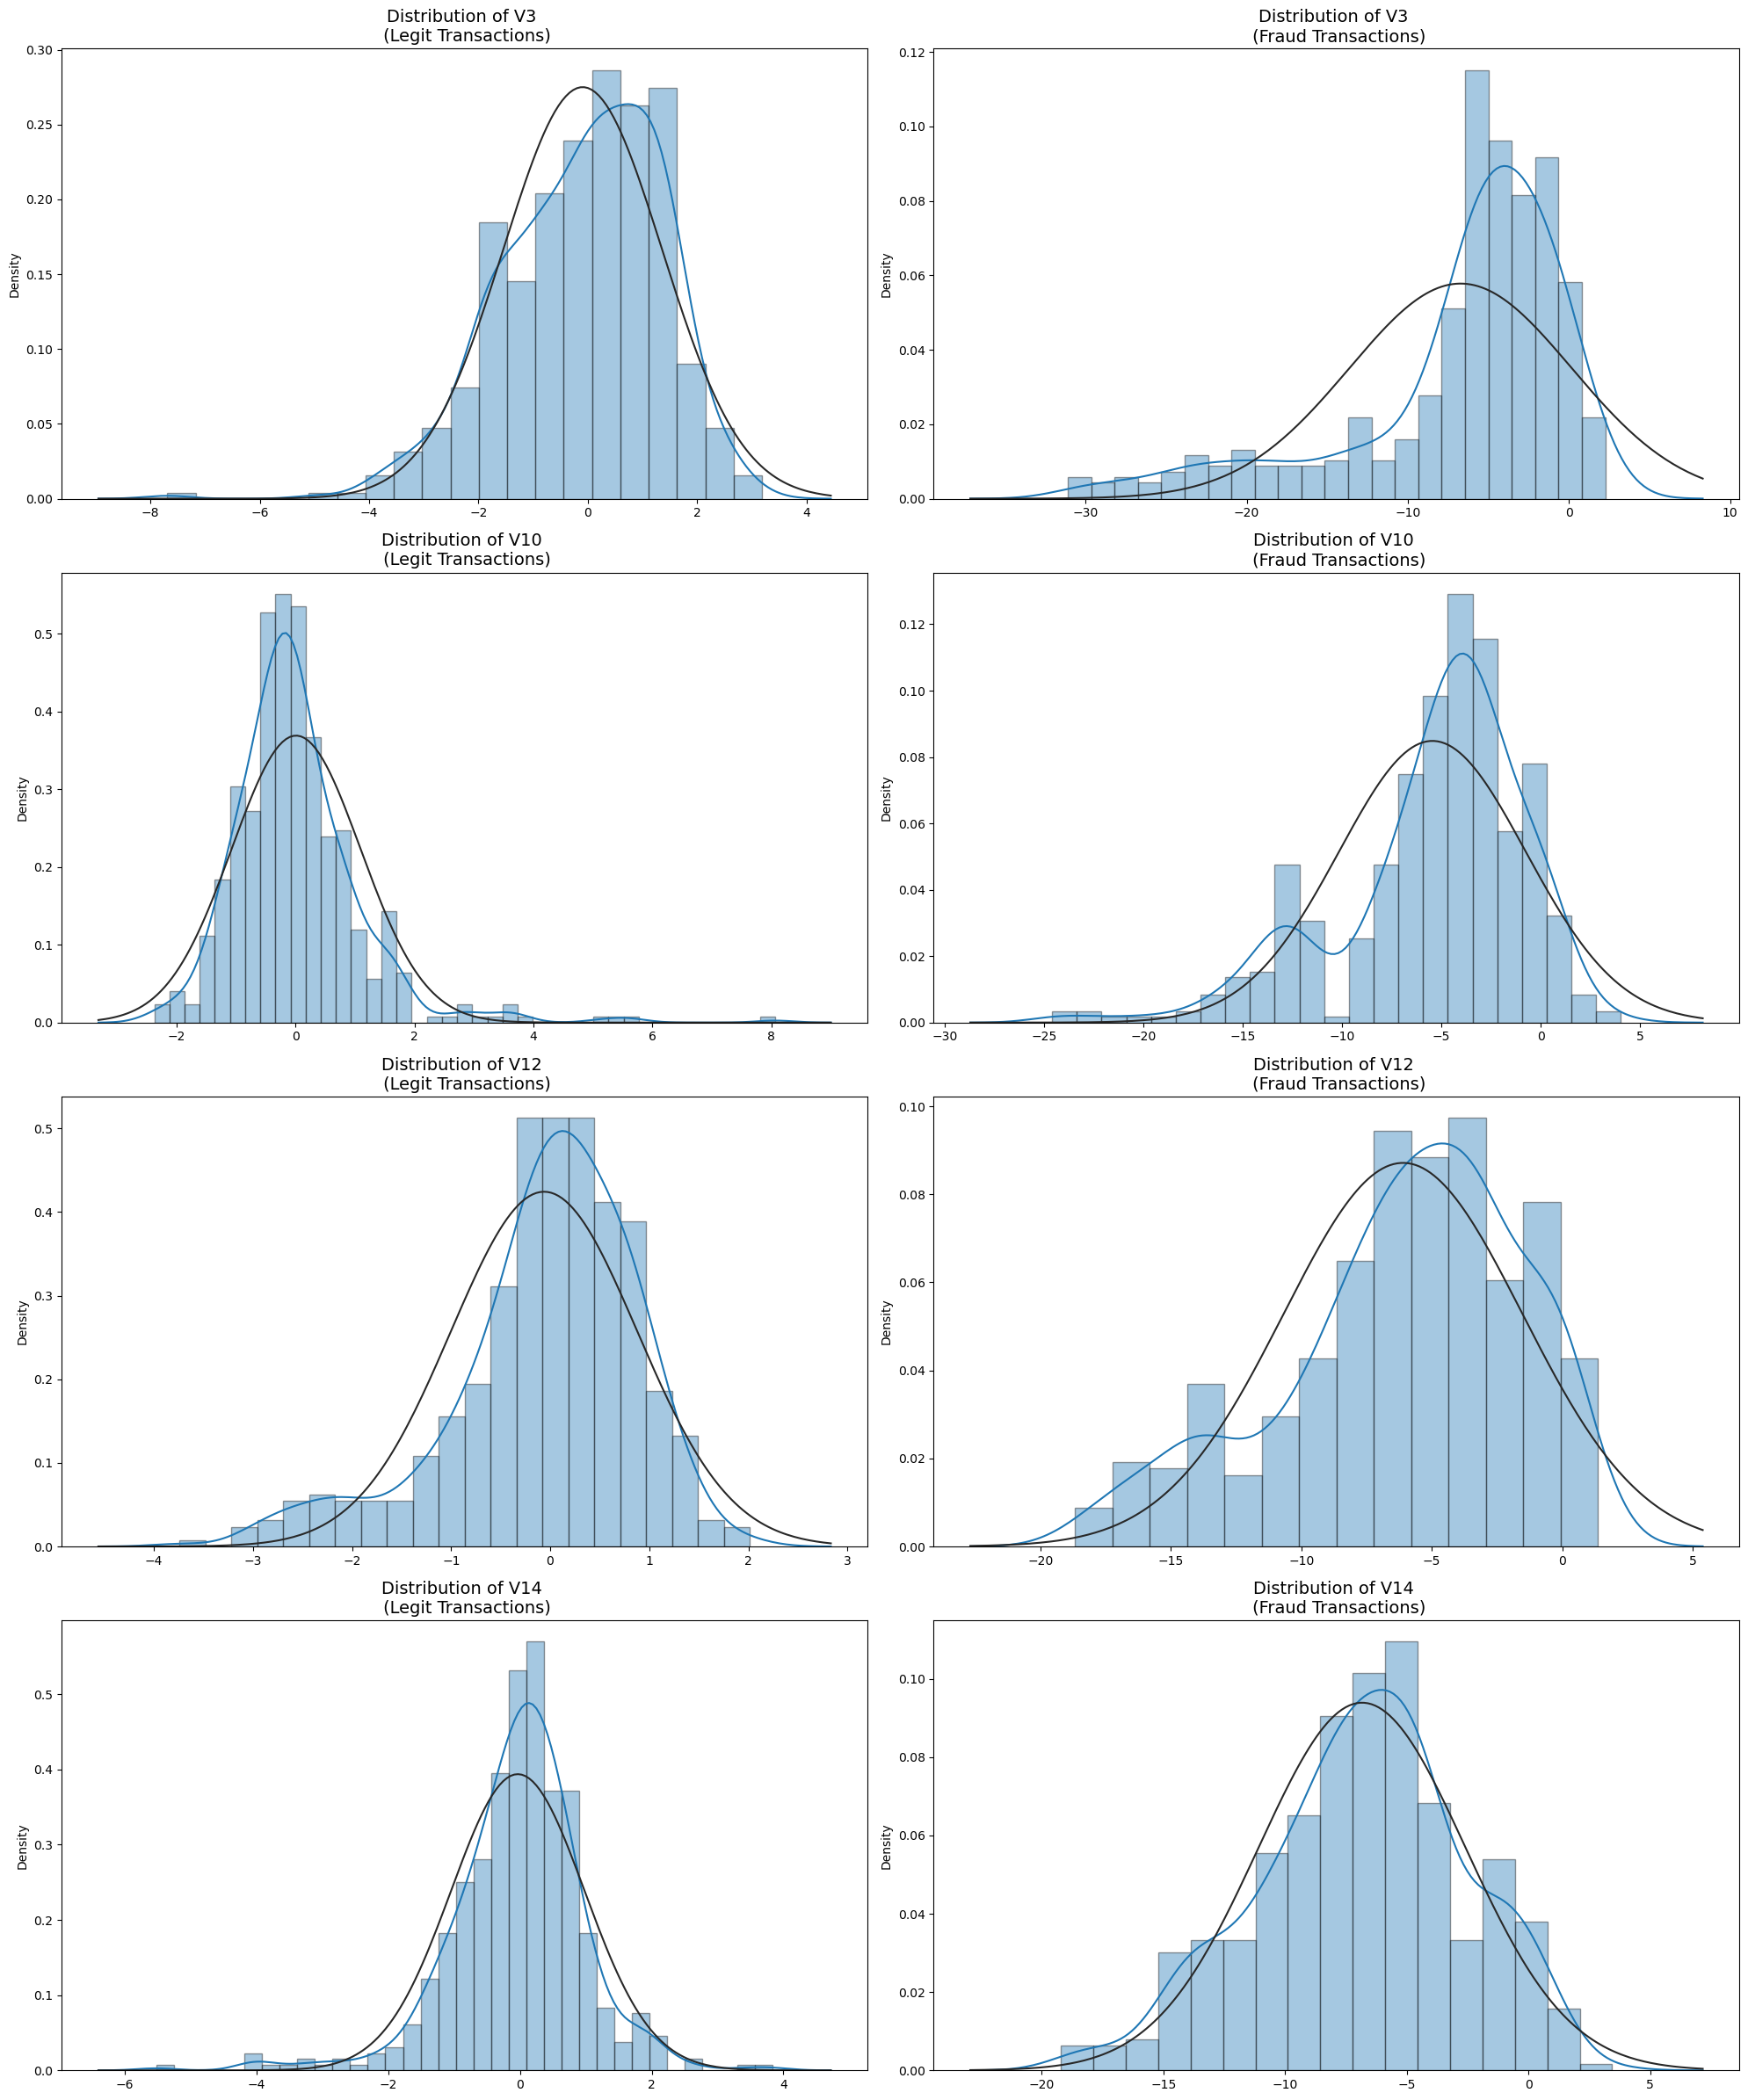

In [121]:
from scipy.stats import norm

# Create subplots
f, ax = plt.subplots(4, 2, figsize=(20, 24))

# Distribution plot for V3
sns.distplot(df_new['V3'].loc[df_new['Class'] == 0].values, ax=ax[0][0], fit=norm, hist_kws={'edgecolor':'black'})
ax[0][0].set_title('Distribution of V3 \n (Legit Transactions)', fontsize=14)
sns.distplot(df_new['V3'].loc[df_new['Class'] == 1].values, ax=ax[0][1], fit=norm, hist_kws={'edgecolor':'black'})
ax[0][1].set_title('Distribution of V3 \n (Fraud Transactions)', fontsize=14)

# Distribution plot for V10
sns.distplot(df_new['V10'].loc[df_new['Class'] == 0].values, ax=ax[1][0], fit=norm, hist_kws={'edgecolor':'black'})
ax[1][0].set_title('Distribution of V10 \n (Legit Transactions)', fontsize=14)
sns.distplot(df_new['V10'].loc[df_new['Class'] == 1].values, ax=ax[1][1], fit=norm, hist_kws={'edgecolor':'black'})
ax[1][1].set_title('Distribution of V10 \n (Fraud Transactions)', fontsize=14)

# Distribution plot for V12
sns.distplot(df_new['V12'].loc[df_new['Class'] == 0].values, ax=ax[2][0], fit=norm, hist_kws={'edgecolor':'black'})
ax[2][0].set_title('Distribution of V12 \n (Legit Transactions)', fontsize=14)
sns.distplot(df_new['V12'].loc[df_new['Class'] == 1].values, ax=ax[2][1], fit=norm, hist_kws={'edgecolor':'black'})
ax[2][1].set_title('Distribution of V12 \n (Fraud Transactions)', fontsize=14)

# Distribution plot for V14
sns.distplot(df_new['V14'].loc[df_new['Class'] == 0].values, ax=ax[3][0], fit=norm, hist_kws={'edgecolor':'black'})
ax[3][0].set_title('Distribution of V14 \n (Legit Transactions)', fontsize=14)
sns.distplot(df_new['V14'].loc[df_new['Class'] == 1].values, ax=ax[3][1], fit=norm, hist_kws={'edgecolor':'black'})
ax[3][1].set_title('Distribution of V14 \n (Fraud Transactions)', fontsize=14)

# Adjust layout
plt.tight_layout()
plt.show()


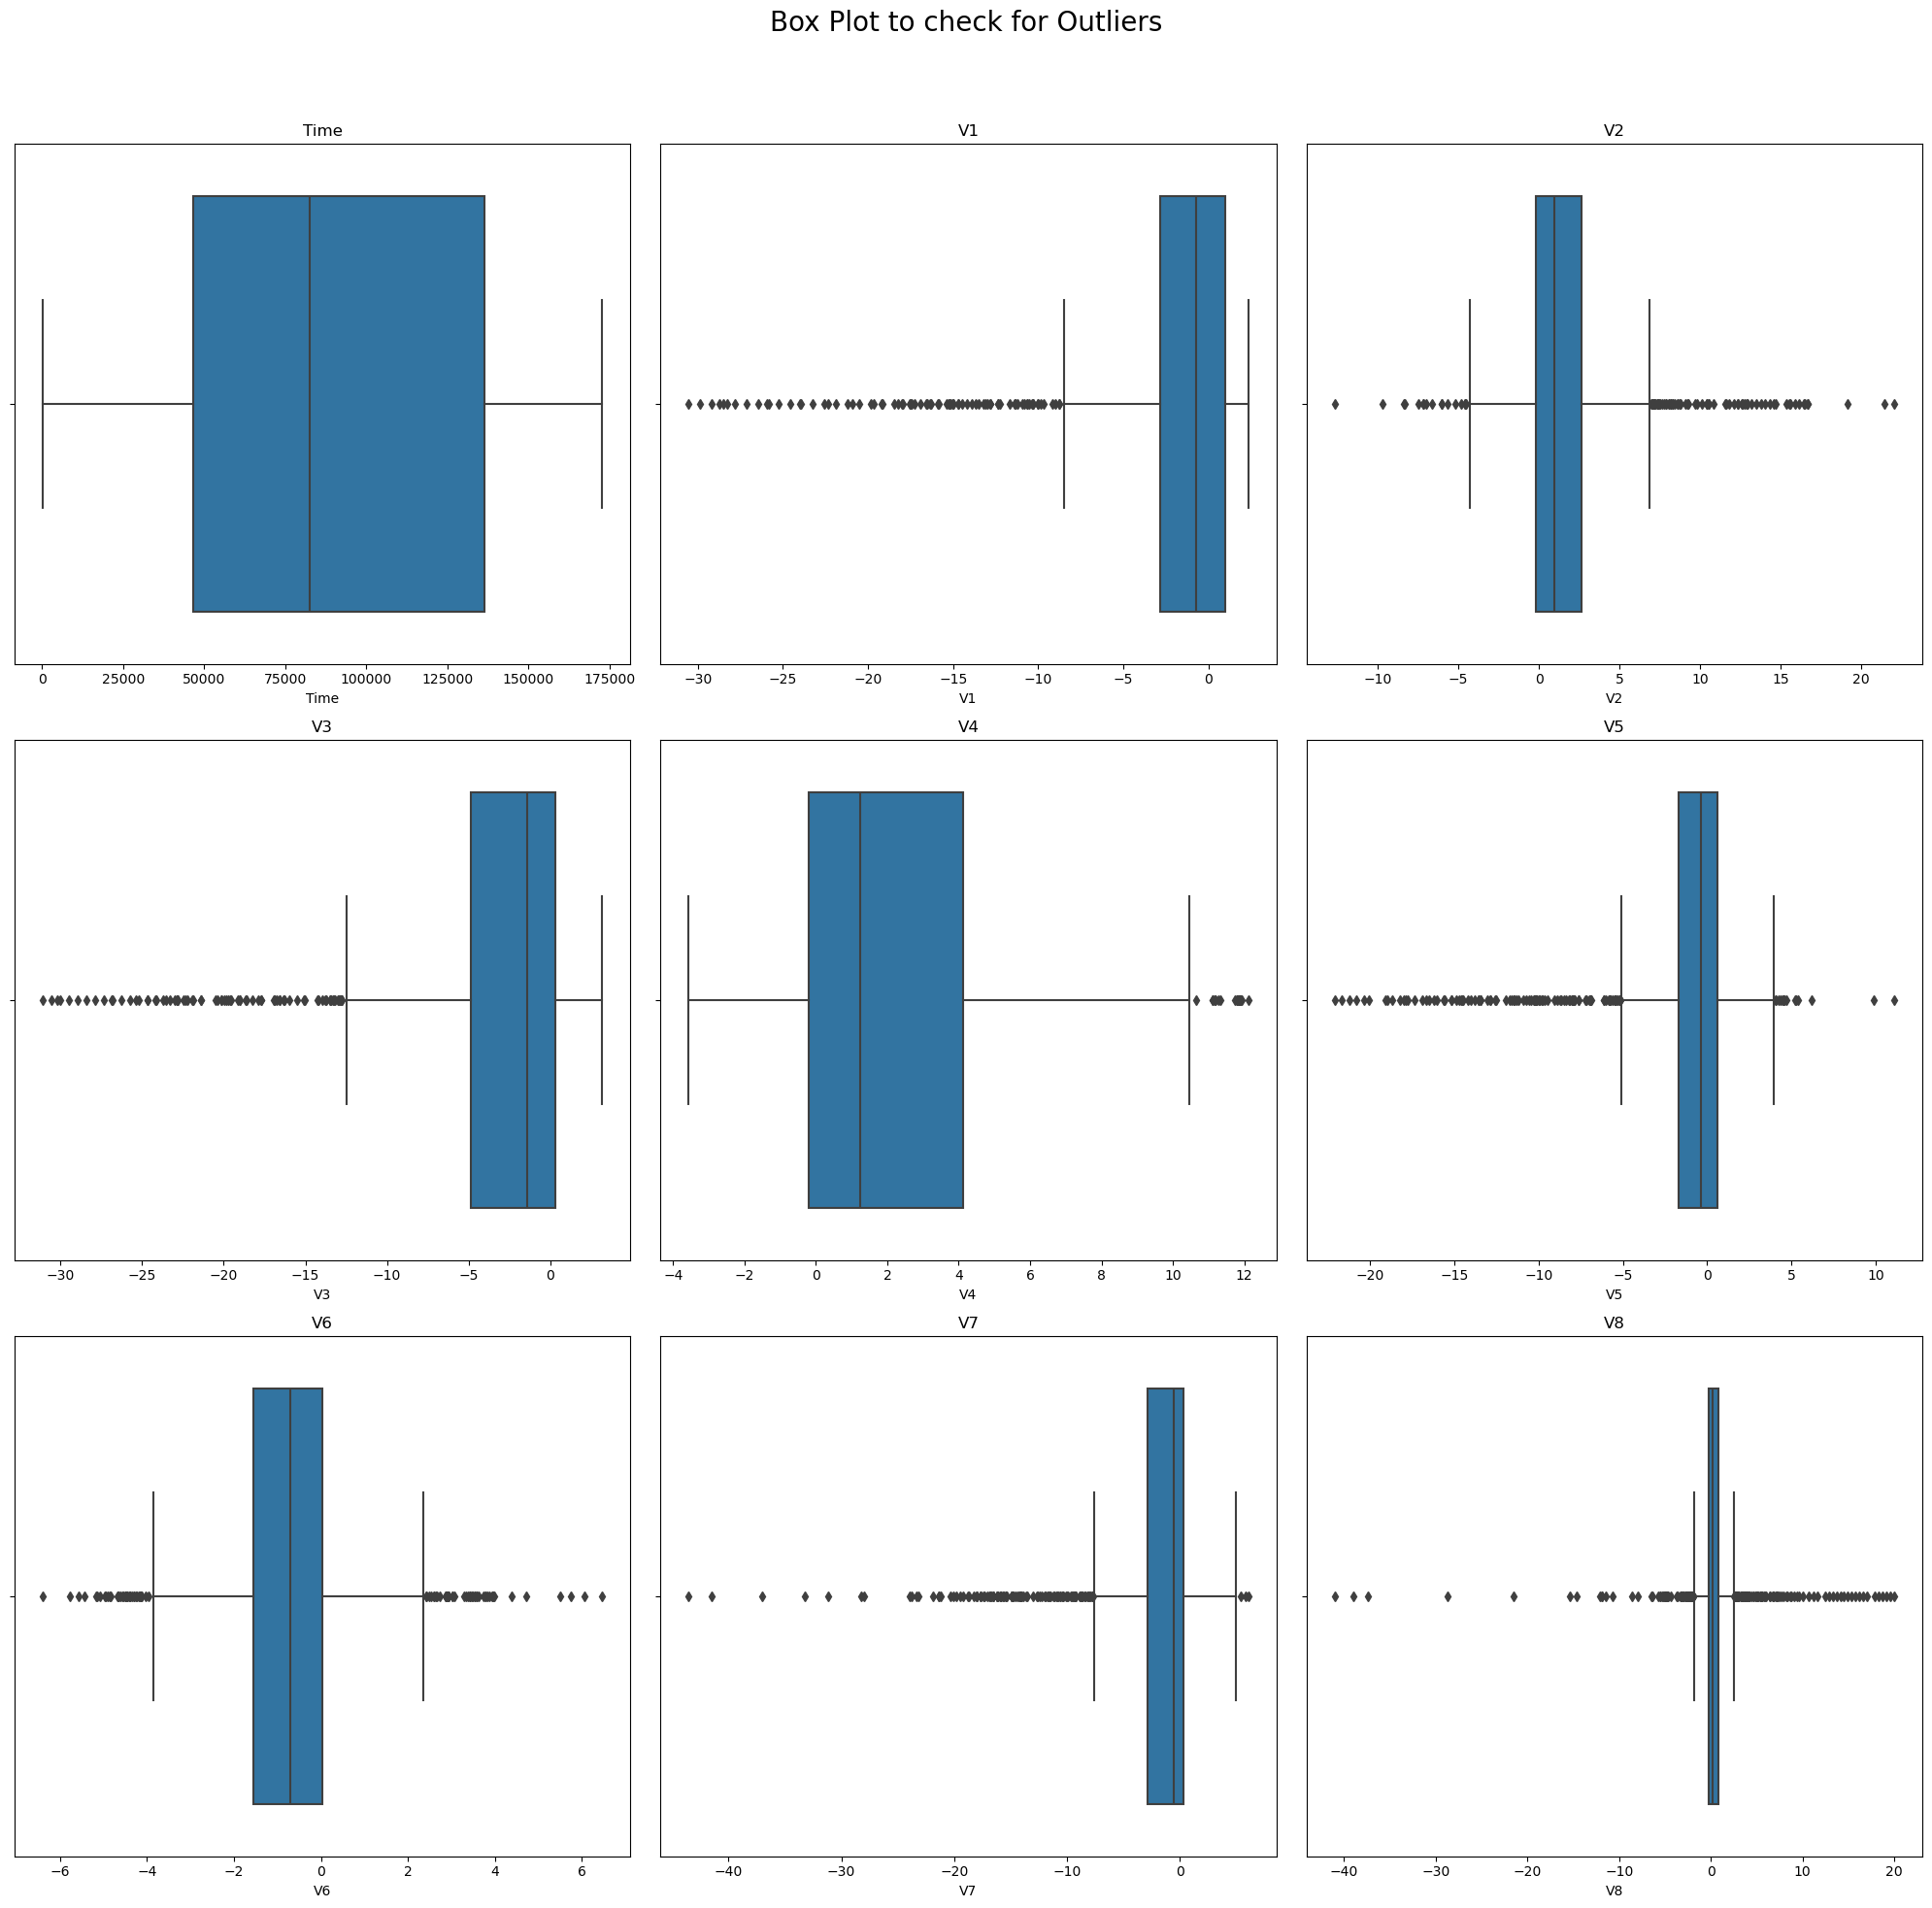

In [122]:
# Create a 3x3 grid of subplots
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
ax = ax.flatten()  # Flatten the array of axes to make indexing easier
fig.suptitle('Box Plot to check for Outliers', fontsize=20)

# Loop through the first 9 columns of the DataFrame and create a boxplot for each
for i, column in enumerate(df.columns[:9]):
    sns.boxplot(data=df_new, x=column, ax=ax[i])
    ax[i].set_title(column)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title and avoid overlap
plt.show()

# Feature selection 

In [123]:
# Feature selection for target & features
X = df_new.drop(columns='Class', axis=1)
y = df_new['Class']

# Spliting into Training & Testing Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2)

print(X.shape, X_train.shape, X_test.shape)

(965, 30) (772, 30) (193, 30)


# Model Training

### Logistic Regression

In [124]:
# Thain the datasetwith Logistic Regression model
model_lgr = LogisticRegression(max_iter=1000)  # Increase max_iter to 1000
model_lgr.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

# Model Evaluation

In [125]:
# accuracy on training data
X_train_prediction = model_lgr.predict(X_train)
train_data_accuracy = accuracy_score(X_train_prediction, y_train)
print('Accuracy on Training data : ', train_data_accuracy)


# accuracy on test data
X_test_prediction = model_lgr.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, y_test)
print('Accuracy score on Test Data : ', test_data_accuracy)

Accuracy on Training data :  0.917098445595855
Accuracy score on Test Data :  0.8756476683937824


In [126]:
##  accuracy on both the training data (91.45%) and test data (90.15%), 

In [127]:
# Predict probabilities for the ROC Curve
y_probs = model_lgr.predict_proba(X_test)[:, 1]

# Predict classes for the Confusion Matrix
y_pred = model_lgr.predict(X_test)

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Compute ROC AUC score using continuous predictions (probabilities)
roc_auc = roc_auc_score(y_test, y_probs)

# Compute accuracy, precision, recall using binary class predictions
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print('ROC AUC Score:', roc_auc)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)

ROC AUC Score: 0.946938775510204
Accuracy: 0.8756476683937824
Precision: 0.8901098901098901
Recall: 0.8526315789473684


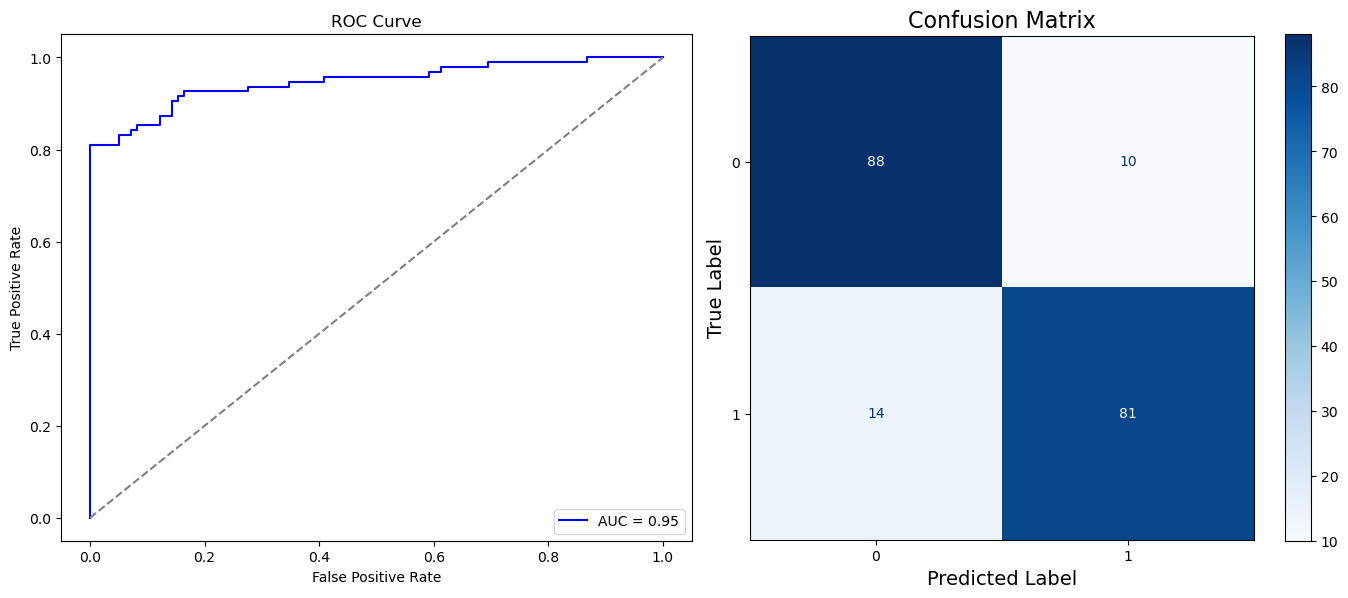

In [128]:
# Predict probabilities for the ROC Curve
y_probs = model_lgr.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

# Predict classes for the Confusion Matrix
y_pred = model_lgr.predict(X_test)

# Create subplots: 1 row, 2 columns
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot ROC Curve
ax[0].plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
ax[0].plot([0, 1], [0, 1], color='gray', linestyle='--')
ax[0].set_title('ROC Curve')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].legend(loc='lower right')

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax[1], cmap='Blues', values_format='d')
# Styling for Confusion Matrix
ax[1].set_title('Confusion Matrix', fontsize=16)
ax[1].set_xlabel('Predicted Label', fontsize=14)
ax[1].set_ylabel('True Label', fontsize=14)

# Adjust layout and show plot
plt.tight_layout()
plt.show()
